In [77]:
import os

initial_triplet_training=False
triplet_training=False
embeddings_size=16
ap_pairs_train=15
an_pairs_train=15
ap_pairs_test=5
an_pairs_test=5

knn_neighbors=15
nc_function='knn'
p_value_type='regular'
significance_levels=np.arange(start=0.001,stop=0.2,step=0.001)

# data_path=os.path.join( os.getcwd(), '..', 'Dataset/SCITOS-G5/' )
data_path='SCITOS-G5/'
triplet_network_arch_path='Saved_Models/triplet_nn_structure.json'
triplet_network_weights_path='Saved_Models/triplet_model_weights.h5'
training_triplets_path='GeneratedData/train_pairs.npy'
validation_triplets_path='GeneratedData/test_pairs.npy'
data_per_class_path='GeneratedData/data_per_class.npy'
triplet_embeddings_path='GeneratedData/triplet_embeddings.pickle'
knn_nc_scores_path='GeneratedData/knn_nc_scores.pickle'
nearest_centroid_nc_scores_path='GeneratedData/nearest_centroid_nc_scores.pickle'
prediction_sets_path='GeneratedData/prediction_sets.pickle'
optimal_epsilon_path='GeneratedData/optimal_epsilon.npy'
test_pvalues_path='GeneratedData/test_pvalues.npy'


In [78]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import csv
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Input, GlobalAveragePooling2D, Lambda, Reshape, Conv2DTranspose, DepthwiseConv2D, concatenate
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras import backend as K
from keras.optimizers import SGD,Adam

In [79]:
config = tf.compat.v1.ConfigProto()
# adjust the amount of memory you allow it to use as needed
config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf.compat.v1.Session(config=config)

In [80]:
path = data_path
sensors_df=pd.read_csv(path+"sensor_readings_24.data",header=None)
le=LabelEncoder()
sensors_df.loc[:,24]=le.fit_transform(sensors_df.loc[:,24])

train_df, test_df= train_test_split(sensors_df,test_size=0.1, random_state=40)
train_df, calibration_df= train_test_split(train_df,test_size=0.2, random_state=42)

data={'x_train':train_df.values[:,:-1],
'y_train': train_df.values[:,-1].astype(int),
'x_validation' : calibration_df.values[:,:-1],
'y_validation' : calibration_df.values[:,-1].astype(int),
'x_test': test_df.values[:,:-1],
'y_test': test_df.values[:,-1].astype(int)}

num_classes=len(set(data['y_test']))

/home/boursid/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


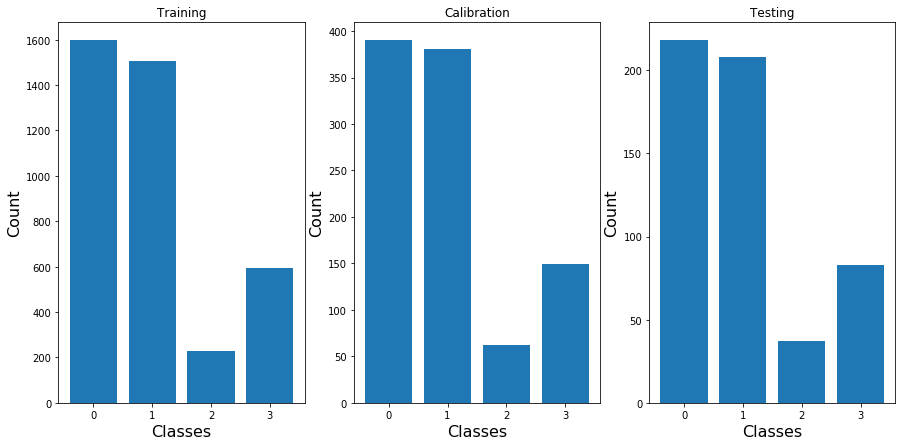

In [81]:
fig=plt.figure()
fig.set_size_inches(15,7)
label_counter=Counter(data['y_train'])
ax1=fig.add_subplot(131)
ax1.set_ylabel('Count',color='k',fontsize=16)
ax1.set_xlabel('Classes',color='k',fontsize=16)
ax1.bar(label_counter.keys(), label_counter.values())
ax1.grid(False)
ax1.set_title("Training")

label_counter=Counter(data['y_validation'])
ax2=fig.add_subplot(132)
ax2.set_ylabel('Count',color='k',fontsize=16)
ax2.set_xlabel('Classes',color='k',fontsize=16)
ax2.bar(label_counter.keys(), label_counter.values())
ax2.grid(False)
ax2.set_title("Calibration")

label_counter=Counter(data['y_test'])
ax3=fig.add_subplot(133)
ax3.set_ylabel('Count',color='k',fontsize=16)
ax3.set_xlabel('Classes',color='k',fontsize=16)
ax3.bar(label_counter.keys(), label_counter.values())
ax3.grid(False)
ax3.set_title("Testing")

fig.show()

In [15]:
def class_separation(x_train,y_train):
    class_idxs=[]
    for data_class in sorted(set(y_train)):
        class_idxs.append(np.where((y_train == data_class))[0])
    return class_idxs

def generate_hard_positives_hard_negatives(x_train,y_train,idxs_per_class,samples_per_class,model):
    num_of_classes=len(set(y_train))
    samples=np.empty((num_of_classes,samples_per_class),dtype='int')
    #pick samples_per_class samples per class
    for data_class in sorted(set(y_train)):
        samples[data_class]=random.sample(list(idxs_per_class[data_class]),k=samples_per_class)

    Anchor=[]
    Positive=[]
    Negative=[]

    count=0
    for data_class in sorted(set(y_train)):
        print("class:",data_class)
        Embeddings_in=model.predict(x_train[samples[data_class]])

        different_classes_idxs=samples[np.arange(len(set(y_train)))!=data_class].flatten()
        Embeddings_out=model.predict(x_train[different_classes_idxs])


        for i in range(samples_per_class):
            Anchor_embedding=Embeddings_in[i]
            other_positives_idxs=np.arange(samples_per_class)[np.arange(samples_per_class)!=i]
            Positive_embeddings=Embeddings_in[other_positives_idxs]
            positive_distances=(Positive_embeddings-Anchor_embedding)**2
            positive_distances=np.sum(positive_distances,axis=1)
            hard_positive_idx=np.argmax(positive_distances)

            negative_distances=(Embeddings_out-Anchor_embedding)**2
            negative_distances=np.sum(negative_distances,axis=1)
            
            for j in range(len(different_classes_idxs)):
                if negative_distances[j]<positive_distances[hard_positive_idx]:
                    Anchor.append(x_train[samples[data_class,i]])
                    Positive.append(x_train[samples[data_class,other_positives_idxs[hard_positive_idx]]])
                    Negative.append(x_train[different_classes_idxs[j]])
        print(len(Anchor))


    Anchor=np.array(Anchor)
    Positive=np.array(Positive)
    Negative=np.array(Negative)

    return Anchor,Positive,Negative

def generate_random_triplets(data,ap_pairs_train,an_pairs_train,ap_pairs_test,an_pairs_test):
    train_xy = tuple([data['x_train'],data['y_train']])
    test_xy = tuple([data['x_validation'],data['y_validation']])

    triplet_train_pairs = []
    triplet_test_pairs = []

    #train
    for data_class in sorted(set(train_xy[1])):
        same_class_idx = np.where((train_xy[1] == data_class))[0]
        diff_class_idx = np.where(train_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs_train) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs_train)
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs:
            Anchor = train_xy[0][ap[0]]
            Positive = train_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = train_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])   

    #test
    for data_class in sorted(set(test_xy[1])):
        same_class_idx = np.where((test_xy[1] == data_class))[0]
        diff_class_idx = np.where(test_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs_test) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs_test)

        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs:
            Anchor = test_xy[0][ap[0]]
            Positive = test_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = test_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])

    print(np.array(triplet_train_pairs).shape)
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [6]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [7]:
# from keras import backend as K
from simple_FF import create_base_model
# from triplet_loss import triplet_loss
    
in_dims=data['x_train'].shape[1:]    
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
base_model=create_base_model(in_dims,embeddings_size,num_classes)
# Shared embedding layer for positive and negative items
anchor_input = Input((in_dims[0], ), name='anchor_input')
positive_input = Input((in_dims[0], ), name='positive_input')
negative_input = Input((in_dims[0], ), name='negative_input')

triplet_DNN=Model(inputs=base_model.input,outputs=base_model.get_layer('embedding').output)
triplet_DNN.summary()

encoded_anchor = triplet_DNN(anchor_input)
encoded_positive = triplet_DNN(positive_input)
encoded_negative = triplet_DNN(negative_input)

merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)
model.summary()

test_model=Model(inputs=anchor_input, outputs=encoded_anchor)
test_model_json=test_model.to_json()

if not os.path.exists('Saved_Models/'):
    os.makedirs('Saved_Models/')
with open(triplet_network_arch_path, "w") as json_file:
    json_file.write(test_model_json)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2500      
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0   

## Training

In [16]:
idxs_per_class=class_separation(data['x_train'],data['y_train'])
callbacks=[]
# callbacks = [CSVLogger('Saved_Models/training.log',separator=' '),
#              EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)]

# model,test_model=create_triplet_nn(config.input_shape[dataset],dataset,nn_type,alpha,embedding_size)

if initial_triplet_training==True:
    X_train,X_test=generate_random_triplets(data,ap_pairs_train,an_pairs_train,ap_pairs_test,an_pairs_test)
    Anchor_test = X_test[:,0,:].reshape(-1,X_test.shape[2],X_test.shape[3],X_test.shape[4])
    Positive_test = X_test[:,1,:].reshape(-1,X_test.shape[2],X_test.shape[3],X_test.shape[4])
    Negative_test = X_test[:,2,:].reshape(-1,X_test.shape[2],X_test.shape[3],X_test.shape[4])
    
    Y_dummy2 = np.empty((Anchor_test.shape[0],1))
    
    Anchor = X_train[:,0,:].reshape(-1,X_train.shape[2],X_train.shape[3],X_train.shape[4])
    Positive = X_train[:,1,:].reshape(-1,X_train.shape[2],X_train.shape[3],X_train.shape[4])
    Negative = X_train[:,2,:].reshape(-1,X_train.shape[2],X_train.shape[3],X_train.shape[4])
    Y_dummy = np.empty((Anchor.shape[0],12))
    model.fit([Anchor,Positive,Negative],
        y=Y_dummy,
        validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2),
        batch_size=triplet_training_batch_size,
        epochs=initial_triplet_training_epochs,
        callbacks=callbacks,
        verbose=1)
    model.save_weights(triplet_network_weights_path)

if triplet_training==True:
    model.load_weights(triplet_network_weights_path)
    for i in range(mining_epochs):
        print("iteration:",i)

        Anchor,Positive,Negative=generate_hard_positives_hard_negatives(data['x_train'],data['y_train'],idxs_per_class,anchor_mining_size,test_model)

        Y_dummy = np.empty((Anchor.shape[0],12))
        model.fit([Anchor,Positive,Negative],
            y=Y_dummy,
            # validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2),
            batch_size=triplet_training_batch_size,
            epochs=1,
            callbacks=callbacks,
            shuffle=True,
            verbose=1)
        model.save_weights(triplet_network_weights_path)

## Generate Embeddings

In [54]:
from keras.models import model_from_json

with open(triplet_network_arch_path, "r") as json_file:
    loaded_model_json=json_file.read()
model=model_from_json(loaded_model_json)
model.load_weights(triplet_network_weights_path)

train_embeds=model.predict(data['x_train'])
calibration_embeds=model.predict(data['x_validation'])
test_embeds=model.predict(data['x_test'])

with open(triplet_embeddings_path, "wb") as f:
    pickle.dump((train_embeds, calibration_embeds, test_embeds), f)

## Evaluate triplet

In [55]:
import seaborn as sns

def scatter(x, labels, filename, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", np.max(labels)+1))

    # We create a scatter plot.
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=5,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(np.max(labels)+1):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=14)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)

    if not os.path.exists('Plots/'):
        os.makedirs('Plots/')
        
    plt.show()
    plt.savefig('Plots/'+"/"+filename)
    plt.close(fig)
    
def confusion_matrix(ground_truth_labels,predicted_labels,title,fsize,path):
    skplt.metrics.plot_confusion_matrix(ground_truth_labels, predicted_labels,title=title,figsize=fsize)
    plt.savefig(path)

Train accuracy: 0.9414460285132383
Calibration accuracy: 0.9195519348268839
Triplet train data silhouette: 0.59527415
Triplet validation data silhouette: 0.5451077


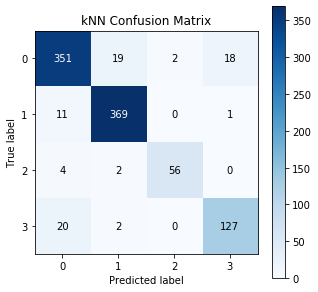

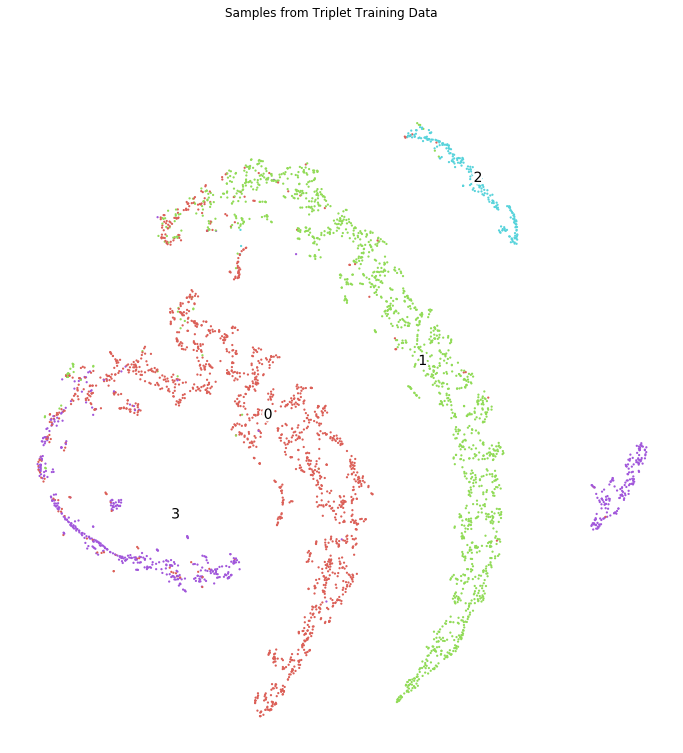

<Figure size 432x288 with 0 Axes>

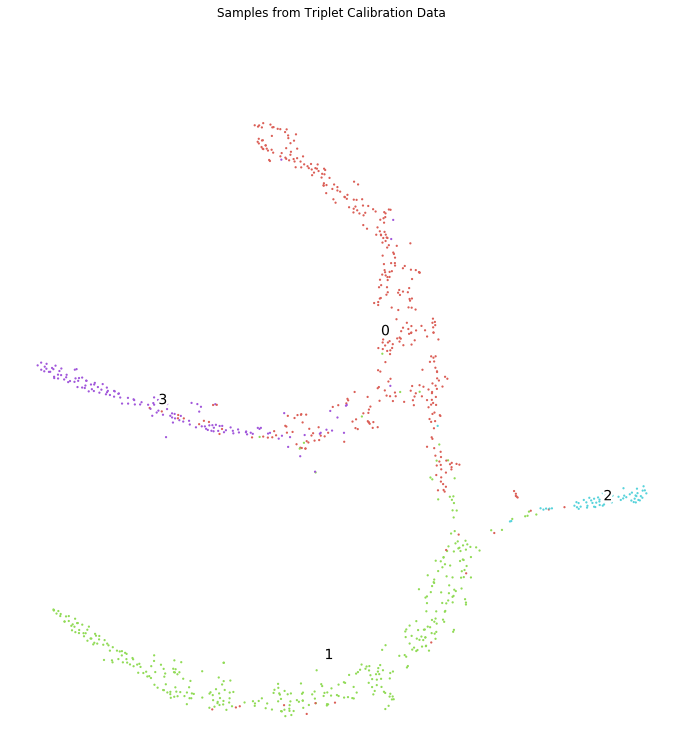

<Figure size 432x288 with 0 Axes>

In [56]:
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import scikitplot as skplt
import matplotlib.patheffects as PathEffects


with open(triplet_embeddings_path, "rb") as f:
    train_embeds, calibration_embeds, test_embeds=pickle.load(f)

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(train_embeds, data['y_train'])
train_predictions=neigh.predict(train_embeds)

calibration_predictions=neigh.predict(calibration_embeds)
print("Train accuracy:",np.sum(train_predictions==data['y_train'])/data['y_train'].shape[0])
print("Calibration accuracy:",np.sum(calibration_predictions==data["y_validation"])/data["y_validation"].shape[0])
print("Triplet train data silhouette:", silhouette_score(train_embeds,data["y_train"]))
print("Triplet validation data silhouette:", silhouette_score(calibration_embeds,data["y_validation"]))

confusion_matrix(data["y_validation"],calibration_predictions,"kNN Confusion Matrix",(5,5),"Plots/confusion_matrix.png")

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(train_embeds[:5000])
scatter(train_tsne_embeds, data['y_train'][:5000], filename='training_scatter', subtitle="Samples from Triplet Training Data")
calibration_tsne_embeds = tsne.fit_transform(calibration_embeds)
scatter(calibration_tsne_embeds, data["y_validation"], filename='calibration_scatter', subtitle="Samples from Triplet Calibration Data")


## ICP Calibration

### K-NN

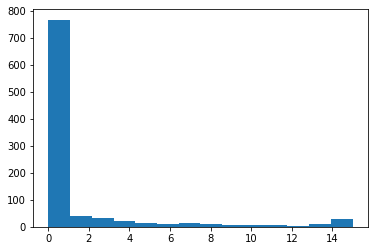

In [57]:
from sklearn.neighbors import NearestNeighbors

with open(triplet_embeddings_path, "rb") as f:
    train_embeds, calibration_embeds, _=pickle.load(f)
    
neigh = NearestNeighbors(n_neighbors=knn_neighbors, algorithm='kd_tree', metric='euclidean')
neigh.fit(train_embeds)
indices=neigh.kneighbors(calibration_embeds, return_distance=False)
calibration_nc=np.empty(len(data['y_validation']))
for i in range(len(data['y_validation'])):
    calibration_nc[i]=np.count_nonzero(data['y_train'][indices[i]]!=data['y_validation'][i])
    
plt.hist(calibration_nc,bins=knn_neighbors-1)

with open(knn_nc_scores_path, "wb") as f:
    pickle.dump((calibration_nc,neigh), f)

### Nearest Centroid

In [58]:
from sklearn.neighbors import NearestNeighbors

with open(triplet_embeddings_path, "rb") as f:
    train_embeds, calibration_embeds, _=pickle.load(f)
    
centroids=np.empty((num_classes,embeddings_size))
for i in range(num_classes):
    centroids[i]=np.mean(train_embeds[data['y_train']==i],axis=0)

calibration_nc=np.empty(len(data['y_validation']))
temp_distances=np.zeros(num_classes)
for i in range(len(data['y_validation'])):
    for j in range(num_classes):
        temp_distances[j]=np.linalg.norm(calibration_embeds[i]-centroids[j])
    calibration_nc[i]=temp_distances[data['y_validation'][i]]/np.min(temp_distances[np.arange(len(temp_distances))!=data['y_validation'][i]])

with open(nearest_centroid_nc_scores_path, "wb") as f:
    pickle.dump((calibration_nc,centroids), f)

### Compute $\epsilon$

Optimal Epsilon: 0.08044806517311609
Discrete Optimal Epsilon: 0.081
Optimal Epsilon Index: 80


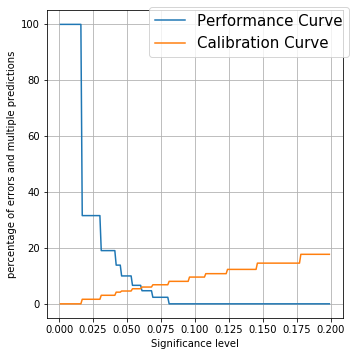

In [59]:
with open(triplet_embeddings_path, "rb") as f:
    _,calibration_embeds,_=pickle.load(f)

p_values=np.empty((len(data['y_validation']),num_classes))
    
if nc_function=='knn':
    with open(knn_nc_scores_path, "rb") as f:
        calibration_nc,train_data_knn=pickle.load(f)
    for i in range(len(data['y_validation'])):
        indices = train_data_knn.kneighbors(calibration_embeds[i].reshape(1, -1), return_distance=False)
        test_ICP_candidates_temp=data['y_train'][indices[0]]
        for j in range(num_classes):
            temp_nc=knn_neighbors-np.count_nonzero(test_ICP_candidates_temp==j)
            if p_value_type=="regular":
                p_values[i,j]=np.count_nonzero(calibration_nc>=temp_nc)/len(calibration_nc)
            if p_value_type=="smooth":
                p_values[i,j]=(np.count_nonzero(calibration_nc>temp_nc)+np.random.uniform(size=1)*np.count_nonzero(calibration_nc==temp_nc))/len(calibration_nc)
        
if nc_function=='nearest_centroid':
    with open(nearest_centroid_nc_scores_path, "rb") as f:
        calibration_nc=pickle.load(f)
    centroid_distances=np.zeros(num_classes)
    for i in range(len(data['y_validation'])):
        for j in range(num_classes):
            centroid_distances[j]=np.linalg.norm(calibration_embeds[i]-centroids[j])
        for j in range(num_classes):
            temp_nc=centroid_distances[j]/np.min(centroid_distances[np.arange(len(centroid_distances))!=j])
            if p_value_type=="regular":
                p_values[i,j]=np.count_nonzero(calibration_nc>=temp_nc)/len(calibration_nc)
            if p_value_type=="smooth":
                p_values[i,j]=(np.count_nonzero(calibration_nc>temp_nc)+np.random.uniform(size=1)*np.count_nonzero(calibration_nc==temp_nc))/len(calibration_nc)

opt_epsilon=np.max(np.sort(p_values,axis=1)[:,-2])
print("Optimal Epsilon:",opt_epsilon)
opt_epsilon_idx=np.searchsorted(significance_levels,opt_epsilon)
print("Discrete Optimal Epsilon:",significance_levels[opt_epsilon_idx])
print("Optimal Epsilon Index:", opt_epsilon_idx)
np.save(optimal_epsilon_path,(opt_epsilon,opt_epsilon_idx))

mult_labels=np.empty(len(significance_levels))
calib=np.empty(len(significance_levels))
for k,sl in enumerate(significance_levels):
    count_mult=0
    count_correct=0
    for i in range(len(data['y_validation'])):
        count_correct+=(data['y_validation'][i] in np.argwhere(p_values[i]>=sl))
        if np.count_nonzero(p_values[i]>=sl)>1:
            count_mult+=1
    mult_labels[k]=count_mult/len(data['y_validation'])
    calib[k]=count_correct/len(data['y_validation'])

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax.plot(significance_levels,mult_labels*100,label='Performance Curve')
ax.plot(significance_levels,(1-calib)*100,label='Calibration Curve')
ax.set_xlabel("Significance level")
ax.set_ylabel("percentage of errors and multiple predictions")
ax.grid()
lgd=fig.legend(fontsize=15)
fig.tight_layout()
plt.savefig("Plots/compute_epsilon", bbox_extra_artists=(lgd,),bbox_inches='tight')

## Test

### P-values computation
Compute the p-values of all the labels for the test data

In [60]:
with open(triplet_embeddings_path, "rb") as f:
    _,_,test_embeds=pickle.load(f)

p_values=np.empty((len(data['y_test']),num_classes))
    
if nc_function=='knn':
    with open(knn_nc_scores_path, "rb") as f:
        calibration_nc,train_data_knn=pickle.load(f)
    for i in range(len(data['y_test'])):
        indices = train_data_knn.kneighbors(test_embeds[i].reshape(1, -1), return_distance=False)
        test_ICP_candidates_temp=data['y_train'][indices[0]]
        for j in range(num_classes):
            temp_nc=knn_neighbors-np.count_nonzero(test_ICP_candidates_temp==j)
            if p_value_type=="regular":
                p_values[i,j]=np.count_nonzero(calibration_nc>=temp_nc)/len(calibration_nc)
            if p_value_type=="smooth":
                p_values[i,j]=(np.count_nonzero(calibration_nc>temp_nc)+np.random.uniform(size=1)*np.count_nonzero(calibration_nc==temp_nc))/len(calibration_nc)
        
if nc_function=='nearest_centroid':
    with open(nearest_centroid_nc_scores_path, "rb") as f:
        calibration_nc=pickle.load(f)
    centroid_distances=np.zeros(num_classes)
    for i in range(len(data['y_test'])):
        for j in range(num_classes):
            centroid_distances[j]=np.linalg.norm(test_embeds[i]-centroids[j])
        for j in range(num_classes):
            temp_nc=centroid_distances[j]/np.min(centroid_distances[np.arange(len(centroid_distances))!=j])
            if p_value_type=="regular":
                p_values[i,j]=np.count_nonzero(calibration_nc>=temp_nc)/len(calibration_nc)
            if p_value_type=="smooth":
                p_values[i,j]=(np.count_nonzero(calibration_nc>temp_nc)+np.random.uniform(size=1)*np.count_nonzero(calibration_nc==temp_nc))/len(calibration_nc)

np.save(test_pvalues_path,p_values)

### Compute the prediction sets
Use the computed p-values of the test set to compute the prediction sets for different values of $\epsilon$

In [62]:
p_values=np.load(test_pvalues_path)

prediction_sets=[]
prediction_set_lengths=np.empty((len(significance_levels),len(data['y_test'])))

for k,sl in enumerate(significance_levels):
    sig_lev_set=[]
    for i in range(len(data['y_test'])):
        temp_set=[]
        for j in range(num_classes):
            if p_values[i,j]>=sl:
                temp_set.append(j)
        sig_lev_set.append(temp_set)
        prediction_set_lengths[k,i]=len(temp_set)
    prediction_sets.append(sig_lev_set)

with open(prediction_sets_path, "wb") as f:
    pickle.dump((prediction_sets,prediction_set_lengths), f)

In [73]:
def compute_multiples_errors(data,p_values,epsilon):
    count_mult=0
    count_correct=0
    for i in range(len(data['y_test'])):
        count_correct+=(data['y_test'][i] in np.argwhere(p_values[i]>=epsilon))
        if np.count_nonzero(p_values[i]>=epsilon)>1:
            count_mult+=1
    mult_labels=count_mult/len(data['y_test'])
    acc=count_correct/len(data['y_test'])
    return mult_labels,1-acc

print("Optimal epsilon", opt_epsilon)
print("Multiple predictions and errors are:",compute_multiples_errors(data,p_values,opt_epsilon))
print("Chosen epsilon 0.05")
print("Multiple predictions and errors are:",compute_multiples_errors(data,p_values,0.05))
print("Chosen epsilon 0.1")
print("Multiple predictions and errors are:",compute_multiples_errors(data,p_values,0.1))

Optimal epsilon 0.08044806517311609
Multiple predictions and errors are: (0.023809523809523808, 0.06959706959706957)
Chosen epsilon 0.05
Multiple predictions and errors are: (0.08974358974358974, 0.0494505494505495)
Chosen epsilon 0.1
Multiple predictions and errors are: (0.0, 0.09706959706959706)
